In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.preprocessing import sequence
# fix random seed for reproducibility
np.random.seed(7)

Using TensorFlow backend.
/Users/mariekorneliusson/anaconda3/envs/dml/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
# Generate a dataset
def generateTestData(dataDim,nbrOfClasses,nbrSamples):
    
    muSigma = np.array([[0,1,1,1.5,0.1,1.3],
                        [0.5,1.75,1.25,1.2,0.5,1],
                        [0.75,0.5,0.7,0.9,0.5,0.8]])
    
    X = np.zeros((nbrSamples,dataDim))
    Y = np.zeros((nbrSamples,nbrOfClasses))
    
    i = 0
    
    while i < nbrSamples:
        nbrSinCluster = int(np.random.rand()*10000)
        cluster = int(np.floor(np.random.rand()*nbrOfClasses))
        if i + nbrSinCluster <= nbrSamples:
            n = i
            for s in range(nbrSinCluster):
                for j in range(3):
                    X[n,j] = np.random.normal(muSigma[cluster,j*2],muSigma[cluster,j*2 + 1])
                Y[n,cluster] = 1
                n = n + 1 
        if i + nbrSinCluster > nbrSamples:
            for s in range(i,nbrSamples):
                for j in range(3):
                    X[s,j] = np.random.normal(muSigma[cluster,j*2],muSigma[cluster,j*2 + 1])
                Y[s,cluster] = 1
        i = i + nbrSinCluster      
    return X,Y

dataDim = 3 #has to be 3, beacouse of how muSigma is defined
nbrOfClasses = 3
nbrSamples = 200000
[X,Y] = generateTestData(3,3,200000)

(200000, 3)


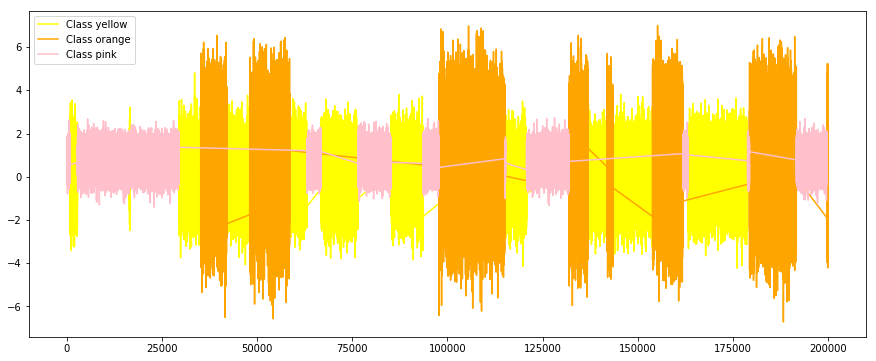

In [3]:
# Plot generated data
tPlot = np.linspace(0,nbrSamples,nbrSamples)
name_dict={0:'yellow',1:'orange',2:'pink'}
i,jY = np.where(Y==1)
plt.figure(0,figsize=(15, 6))
for i in range(nbrOfClasses):
    indC =np.isin(jY, i)
    plt.plot(tPlot[indC],X[indC,0],c =name_dict[i],label='Class ' + name_dict[i])
plt.legend()

In [4]:
# Reshape data and split to train and test.
from sklearn.model_selection import train_test_split

timesteps = 1
X = X.reshape(nbrSamples,timesteps,dataDim)
Y = Y.reshape(nbrSamples,timesteps,dataDim)
trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.2, random_state=10)
print(trainX.shape)
print(trainY.shape)

(160000, 1, 3)
(160000, 1, 3)


Next create the model. 

In [5]:
# Input shape of data (nbrSamples,timeSteps=1,features)
model = Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(timesteps, dataDim)))
model.add(Dense(nbrOfClasses, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1, 50)             10800     
_________________________________________________________________
dense_1 (Dense)              (None, 1, 3)              153       
Total params: 10,953
Trainable params: 10,953
Non-trainable params: 0
_________________________________________________________________
None


In [6]:
model.fit(trainX, trainY, epochs=20, batch_size=100, validation_split=0.25)

Train on 120000 samples, validate on 40000 samples
Epoch 1/20
120000/120000 [==============================] - 7s 62us/step - loss: 0.8656 - categorical_accuracy: 0.5996 - val_loss: 0.8084 - val_categorical_accuracy: 0.6268
Epoch 2/20
120000/120000 [==============================] - 6s 51us/step - loss: 0.8055 - categorical_accuracy: 0.6297 - val_loss: 0.8067 - val_categorical_accuracy: 0.6281
Epoch 3/20
120000/120000 [==============================] - 6s 50us/step - loss: 0.8046 - categorical_accuracy: 0.6304 - val_loss: 0.8050 - val_categorical_accuracy: 0.6271
Epoch 4/20
120000/120000 [==============================] - 6s 50us/step - loss: 0.8042 - categorical_accuracy: 0.6308 - val_loss: 0.8049 - val_categorical_accuracy: 0.6282
Epoch 5/20
120000/120000 [==============================] - 6s 54us/step - loss: 0.8038 - categorical_accuracy: 0.6301 - val_loss: 0.8053 - val_categorical_accuracy: 0.6285
Epoch 6/20
120000/120000 [==============================] - 6s 50us/step - loss: 0.8

In [23]:
from sklearn.metrics import accuracy_score

predY = model.predict(testX)

yTestClass = np.argmax(testY, axis=2)
yPredClass = np.argmax(predY, axis=2)
indC,inCol =np.where(yTestClass == i)
tPlot = np.linspace(0,nbrSamples,nbrSamples)
acc = accuracy_score(yTestClass, yPredClass)
print("Accuracy: %.2f" % acc)

Accuracy: 0.63


ValueError: Image size of 876x600025 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1080x432 with 1 Axes>

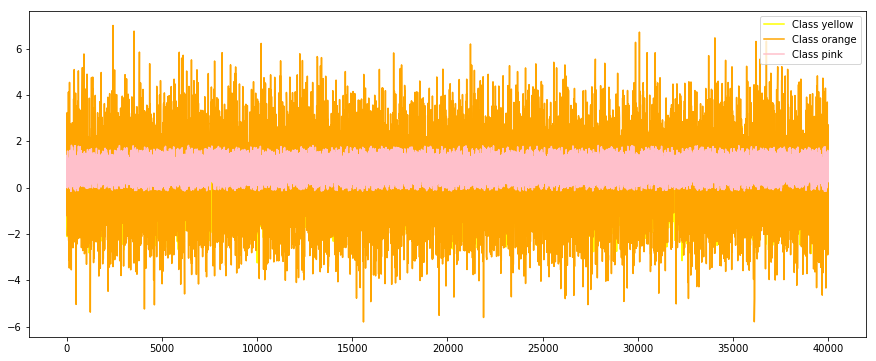

In [22]:
#Plot results
nbrSamples = testX.shape[0]
tPlot = np.linspace(0,nbrSamples,nbrSamples)
name_dict={0:'yellow',1:'orange',2:'pink'}
#plot for test data
plt.figure(0,figsize=(15, 6))
for i in range(nbrOfClasses):
    indC,inCol =np.where(yTestClass == i)
    plt.plot(tPlot[indC,testX[indC,0,0],c =name_dict[i],label='Class ' + name_dict[i])
plt.legend()
#plot for test data
plt.figure(1,figsize=(15, 6))
for i in range(nbrOfClasses):
    indC =np.isin(yPredClass, i)[:,0]
    plt.plot(tPlot[indC],testX[indC,0,0],c =name_dict[i],label='Class ' + name_dict[i])
plt.legend()